<a href="https://colab.research.google.com/github/frapasti/Human-Hands/blob/main/Yolo_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [2]:
!pip install natsort
import os
from natsort import natsorted
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import imutils
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from math import trunc

from keras.models import Sequential 

from keras.layers.core import Dense, Dropout, Activation 
from keras.utils import np_utils
from keras.layers import LeakyReLU                        

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing google drive into google colab.

All the dataset images and ground truth boxes have been saved in different zip files



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip drive/My\ Drive/Datasets/egoHands.zip

Archive:  drive/My Drive/Datasets/egoHands.zip
replace egoHands/boundingboxes/boundingbox_1_1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data organization for YOLO

Get all the bboxes path and all the img_paths
Additionally read all the text files corresponding to the bounding boxes and append them to a list.
**bboxes** contains lists of bounding boxes, one per image

In [4]:
#Get from the unzipped dataset the list of all the paths of images and txt files
#listdir returns unsorted so use natsorted method!
bboxes_paths = natsorted(listdir_fullpath('/content/egoHands/boundingboxes'))
img_paths = natsorted(listdir_fullpath('/content/egoHands/frames'))

assert len(bboxes_paths) == len(img_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

#Read all the text files and create a list of list of bounding boxes, one list per image 
bboxes = []*len(bboxes_paths)
for path in bboxes_paths:
  bboxes_it = []
  file = open(path, 'r')
  Lines = file.readlines()
  for line in Lines:
    bboxes_it.append([int(x) for x in line.split(',')])
  bboxes.append(bboxes_it)

The following cell scale down every image to have a size of 416x416 as required by the input of the network and appends the new images arrays to **scaled_images**.

Additionally it performs some modifications to the bounding boxes, transforming them from the original format to the 416x416 format and creating the list **scaled_bboxes**

**N.B. :** The expected execution time of the next cell is 1 min 30 sec

In [111]:
scale = 500/len(img_paths)
scaled_bboxes = []*int(len(bboxes_paths)*scale)
scaled_images = []*int(len(img_paths)*scale)
for i in range(0,int(len(img_paths)*scale)):
  # store the original image parameters
  original_img = load_img(img_paths[i])
  width, height = original_img.size
  # load the image with the required size and calculate scale factors
  image = load_img(img_paths[i], target_size=(448, 448))
  scale_w = 448 / width 
  scale_h = 448 / height
  # for each bounding box of the image calculate its correspondent one in 416x416 format  
  bboxes_it = []
  for box in bboxes[i]:
    xleft = int(box[0] * scale_w)
    yleft = int(box[1] * scale_h)
    b_width = int(box[2] * scale_w)
    b_height = int(box[3] * scale_h)
    new_bbox = [xleft,yleft,b_width,b_height]
    bboxes_it.append(new_bbox)
  scaled_bboxes.append(bboxes_it)
  # convert the image to the array format required by the CNN
  image = img_to_array(image)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  scaled_images.append(image)

**TESTING** :
In the following cell, some testing can be performed to visualize the scaled down version of the image and the corresponding scaled down bounding box. Just change the variable *number* to see different results

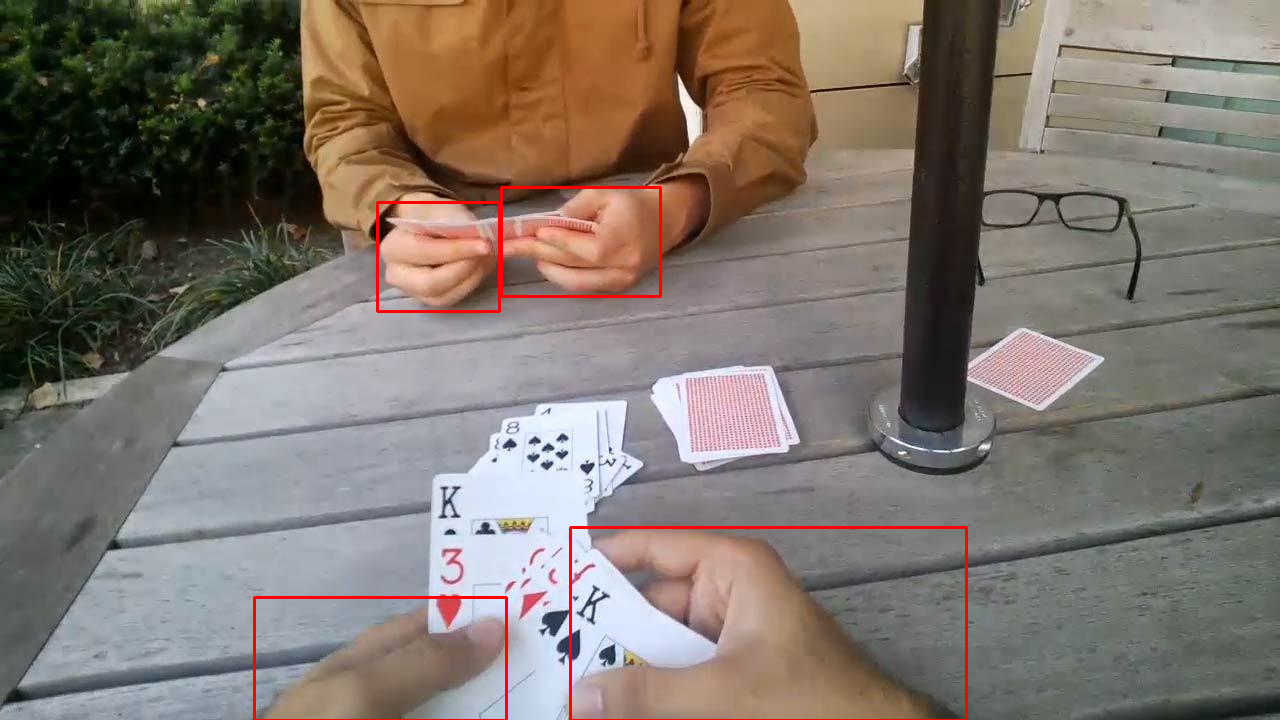

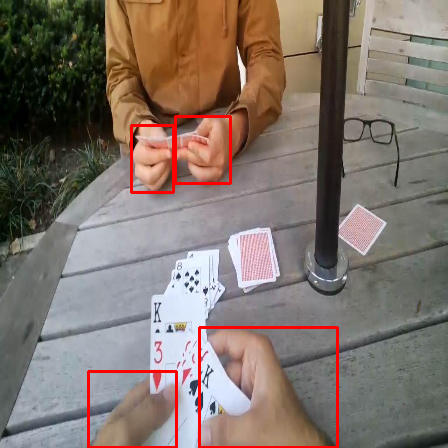

In [6]:
number = 123

image = cv2.imread(img_paths[number])
      
# Drawing the regions in the Image
for (x, y, w, h) in bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
cv2_imshow(image) 

image = cv2.imread(img_paths[number])
      
# Resizing the Image
image = cv2.resize(image,(448,448))

# Drawing the regions in the Image
for (x, y, w, h) in scaled_bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
  
cv2_imshow(image)

Now create the grid of cells that Yolo analyzes.
The size of the grid is 8x8 meaning that each cell will have a size of 52x52.

For each bounding box calculate its center, the center will be the grid at which the bounding box is associated.
Each grid cell has a bounding box associated with it (zero if no bounding box). The bounding box has this form [P, Ox, Oy, W, H]:


*   P = probability that there's a hand (always 1 since we are taking ground truth boxes)
*   Ox = X center of the bounding box w.r.t to that grid, each grid has coordinates defined by (0,0) and (1,1) being respectively the up-left and down-rigth corner of such grid
*   Oy = Y center with same reasoning as above
*   W = width of the bounding box w.r.t the grid size
*   H = height of the bounding box w.r.t. the grid size

So, as an example, a bounding box b = [208,208,104,104] will be associated to the cell at row = 3 and column = 3 and become b_new = [1 ,0.5 ,0.5 , 2, 2]



In [115]:
S = 7 # number of grids, if for example S = 8 the image will be divided into a frid 8x8
cell_size = 448/S # Number of pixels per cell
Y_train = []*len(scaled_bboxes) # Ground truth of the network the size is 8x8(Grid)x5(One bounding box with associated prob per cell) for each image
# Iterate over all the scaled boxes 
for i in range(0,len(scaled_bboxes)):
  Y_net = np.zeros((S,S,5))
  for (x, y, w, h) in scaled_bboxes[i]:
    # Calculate the coordinates of the center of the bbox w.r.t the whole image
    ox = x + w/2
    oy = y + h/2
    # Calculate the coordinates of the cell in the grid that contains the center 
    grid_col = trunc(ox/cell_size) # - 1 because the coordinates are from 0 to S - 1 not from 1 to S
    grid_row = trunc(oy/cell_size) 
    # Calculate the coordinates of the center of the bbox w.r.t the associated cell; (0,0) top left and (1,1) bottom right corners of the cell
    ox_cell = (ox - (grid_col)*cell_size)/cell_size
    oy_cell = (oy - (grid_row)*cell_size)/cell_size
    # Calculate the width and height of the bbox in terms of cell size, a bbox of width 448/S(cell size) will have grid_width = 1
    grid_width = w/cell_size
    grid_heigth = h/cell_size
    # Put the results into y; 1 represent the probability of the class
    y = [1,ox_cell,oy_cell,grid_width,grid_heigth]
    #Put y in the correct position of the ground truth
    Y_net[grid_row][grid_col] = y
  Y_train.append(Y_net)

# YOLO CNN
Creation of a Yolo model using Keras

In [116]:
print("X train shape : " + str(len(scaled_images)) + " x " + str(scaled_images[0].shape))
print("Y train shape : " + str(len(Y_train)) + " x " + str(Y_train[0].shape))

X train shape : 500 x (448, 448, 3)
Y train shape : 500 x (7, 7, 5)


In [117]:
X = np.array(scaled_images)
Y = np.array(Y_train)

X_train = X[0:450]
Y_train = Y[0:450]

X_test = X[450:500]
Y_test = Y[450:500]

In [118]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(500, 448, 448, 3)
(500, 7, 7, 5)
(450, 448, 448, 3)
(450, 7, 7, 5)
(50, 448, 448, 3)
(50, 7, 7, 5)


# IF WANT TO USE PRE TRAINED MODEL
Compile this cells, otherwise not


In [48]:
from tensorflow import keras
from keras.models import Model
tf.keras.backend.clear_session()
yolo_pretrained = keras.models.load_model('/content/drive/MyDrive/Model3')
yolo_pretrained.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, None, 64)    0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                        

In [49]:
from keras.models import Model

yolo = Sequential()

classif_yolo = Model(yolo_pretrained.input, yolo_pretrained.layers[-5].output)

yolo.add(classif_yolo)
yolo.add(tf.keras.layers.Reshape((1568,), input_shape=(7,7,32)))


for layer in yolo.layers[:]:
    layer.trainable = False

layer1 = Dense(245, activation = 'relu')
yolo.add(layer1)
layer1.trainable = True

layer2 = tf.keras.layers.Reshape((7,7,5), input_shape=(245,))
yolo.add(layer2)
layer2.trainable = True

for layer in yolo.layers:
  print(layer, layer.trainable)

yolo.summary()

<keras.engine.functional.Functional object at 0x7f1a7ee7fa90> False
<keras.layers.core.reshape.Reshape object at 0x7f1a7e9366d0> False
<keras.layers.core.dense.Dense object at 0x7f1a88785950> True
<keras.layers.core.reshape.Reshape object at 0x7f1a872a6f10> True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, None, None, 32)    291136    
                                                                 
 reshape (Reshape)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 245)               384405    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 5)           0         
                                                                 
Total params: 675,541
Trainable params: 384,405
Non-train

# FOR STANDARD MODEL NOT PRE-TRAINED
compile this cells

In [119]:
tf.keras.backend.clear_session()
from keras.regularizers import l2

yolo = Sequential()
lrelu = LeakyReLU(alpha=0.1)
yolo.add(tf.keras.layers.Conv2D(32, (7, 7), padding="same", activation = lrelu, strides = (1,1), input_shape=(448,448,3), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4) ))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (1, 1), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Flatten())

yolo.add(Dense(245))

yolo.add(tf.keras.layers.Reshape((7,7,5), input_shape=(245,)))


yolo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        4160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

# LOSS FUNCTIONS
Which one will work? :))))) :((((

In [120]:
def custom_loss(y_true, y_pred):
  
  mse = tf.keras.losses.MeanSquaredError(reduction = "sum")
  predictions = tf.reshape(y_pred,(-1,7,7,5))
  exists_box = tf.expand_dims(y_true[...,0], 3)

  #BOX LOSS
  pred_box = exists_box*predictions[...,1:5]
  target_box = exists_box*y_true[...,1:5]

  epsilon = tf.fill(pred_box[..., 2:4].shape, 1e-6)
  wh_pred = tf.math.sign(pred_box[...,3:5]) * tf.math.sqrt(tf.math.abs(pred_box[...,3:5] + epsilon))
  wh_targ = tf.math.sqrt(target_box[...,3:5] + epsilon)

  xy_pred = pred_box[...,1:3]
  xy_true = target_box[...,1:3]

  final_pred_box = tf.concat([xy_pred,wh_pred], axis = 3)
  final_true_box = tf.concat([xy_true,wh_targ], axis = 3)
  box_loss = mse(tf.reshape(final_pred_box, (-1, final_pred_box.shape[-1])),tf.reshape(final_true_box, (-1, final_true_box.shape[-1])))
  

  #OBJECT LOSS
  pred_obj = predictions[...,0:1]
  true_obj = y_true[...,0:1]

  object_loss = mse(tf.reshape(exists_box*pred_obj, (-1, )), tf.reshape(exists_box*true_obj, (-1, )) )

  #NO OBJECT LOSS
  non_exists_box = 1 - exists_box
  no_object_loss = mse(tf.reshape(non_exists_box*pred_obj, (-1, )), tf.reshape(non_exists_box*true_obj, (-1, )))

  total_loss = 5*box_loss + object_loss + 0.5*no_object_loss
  return total_loss

In [121]:
x = tf.random.uniform((2, 7, 7, 5))
y = tf.random.uniform((2, 7, 7, 5))
custom_loss(x,y)

<tf.Tensor: shape=(), dtype=float32, numpy=24.045418>

In [122]:
yolo.compile(loss=custom_loss, optimizer='adam', metrics = ['accuracy'])

In [123]:
yolo.fit(X_train, Y_train, batch_size=25, epochs=25, verbose=1)

Epoch 1/25
18/18 [==============================] - 138s 8s/step - loss: 75.1216 - accuracy: 0.1920
Epoch 2/25
18/18 [==============================] - 133s 7s/step - loss: 25.7084 - accuracy: 0.1329
Epoch 3/25
18/18 [==============================] - 135s 8s/step - loss: 21.9968 - accuracy: 0.0903
Epoch 4/25
18/18 [==============================] - 133s 7s/step - loss: 19.8846 - accuracy: 0.0847
Epoch 5/25
18/18 [==============================] - 138s 8s/step - loss: 16.5289 - accuracy: 0.0813
Epoch 6/25
18/18 [==============================] - 134s 7s/step - loss: 13.2071 - accuracy: 0.0847
Epoch 7/25
18/18 [==============================] - 137s 8s/step - loss: 11.2935 - accuracy: 0.0851
Epoch 8/25
18/18 [==============================] - 133s 7s/step - loss: 8.7551 - accuracy: 0.0908
Epoch 9/25
18/18 [==============================] - 138s 8s/step - loss: 7.4242 - accuracy: 0.0883
Epoch 10/25
18/18 [==============================] - 135s 8s/step - loss: 6.2816 - accuracy: 0.0917
Ep

In [132]:
def decode_net_out(out):
  #out has shape 7x7x5
  #For each cell get the bounding boxes
  bboxes = []
  for i in range(0,7):
    for j in range(0,7):
      if out[i][j][0] > 0.6:
        bbox = np.zeros((4))
        ox_cell = out[i][j][1]
        oy_cell = out[i][j][2]
        w_cell = out[i][j][3]
        h_cell = out[i][j][4]
        if(ox_cell != 0 and oy_cell !=0):
          ox = trunc(ox_cell*cell_size + cell_size*j)
          oy = trunc(oy_cell*cell_size + cell_size*i)
          w = w_cell*cell_size
          h = h_cell*cell_size
          lx = ox - w/2
          ly = oy - h/2
          bbox = [int(lx),int(ly),int(w),int(h)]
          bboxes.append(bbox)
  return bboxes

(448, 448, 3)
(1, 448, 448, 3)


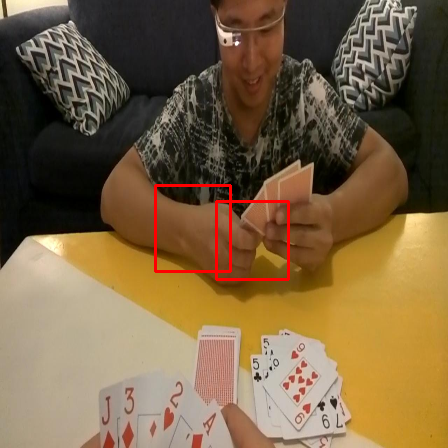

In [148]:
number = 487


image = cv2.imread(img_paths[number])
image = cv2.resize(image,(448,448))

in_net = load_img(img_paths[number], target_size=(448, 448))
in_net = X_test[number - 450]
print(in_net.shape)
in_net = np.expand_dims(in_net, axis=0)
print(in_net.shape)
out_net = yolo.predict(in_net)
out_bboxes = decode_net_out(out_net[0])

# Drawing the regions in the Image
for (x, y, w, h) in out_bboxes:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
cv2_imshow(image) 

In [150]:
yolo.save('/content/drive/MyDrive/YOLO1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/YOLO1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/YOLO1/assets
